In [110]:
import glob
import netCDF4
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
sns.set()

# 2. Climate data from CRU
- Use four types of CRU climate data min, max, average temperatures, and precipitation.
`https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.04/cruts.2004151855.v4.04/tmn`<br>
`https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.04/cruts.2004151855.v4.04/tmp`<br>
`https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.04/cruts.2004151855.v4.04/tmx`<br>
`https://crudata.uea.ac.uk/cru/data/hrg/cru_ts_4.04/cruts.2004151855.v4.04/pre`<br>


- Use latitude and longitude of Kunduz, Ghazni, and Kabul and extract pixel values for CRU min, max, average temperatures, and precipitation

- Plot your time-series data where x-axis refers to time (year-month) and y-axis refers to temperatures and precipitation for each of districts (Kunduz, Ghazni, and Kabul)

## 2.1 Validate keys and dimensions
- Common keys are `lat`, `lon`, `time`
- Keys of interest: `tmn`, `tmx`, `tmp`, `pre`
- All data have the same dimensions: `time`, `lat`, `lon`

```
min -> odict_keys(['lon', 'lat', 'time', 'tmn', 'stn']) - Minimum Temperature
max -> odict_keys(['lon', 'lat', 'time', 'tmx', 'stn']) - Maximum Temperature   
avg -> odict_keys(['lon', 'lat', 'time', 'tmp', 'stn']) - Mean Temperature
pre -> odict_keys(['lon', 'lat', 'time', 'pre', 'stn']) - Precipitation

dimensions = ('time', 'lat', 'lon')
```

In [73]:
types = {'min': 'tmn', 
         'max': 'tmx', 
         'avg': 'tmp',
         'pre': 'pre'}

for tp, name in types.items():
    print(f'Type = {tp}, Name = {name}')
    print('-'*28)
    
    for nc_file in glob.glob(f'data/climate_{tp}/*.nc'):
        nc = netCDF4.Dataset(nc_file, mode='r')
        print(f'NC File Name: {nc_file}')
        print(f'  Keys: {nc.variables.keys()}')
        
        name_data = nc.variables[name]
        print(f'  Dimensions: {name_data.dimensions}\n')
        
    print('='*28)

Type = min, Name = tmn
----------------------------
NC File Name: data/climate_min\cru_ts4.04.2011.2019.tmn.dat.nc
  Keys: odict_keys(['lon', 'lat', 'time', 'tmn', 'stn'])
  Dimensions: ('time', 'lat', 'lon')

NC File Name: data/climate_min\cru_ts4.04.1981.1990.tmn.dat.nc
  Keys: odict_keys(['lon', 'lat', 'time', 'tmn', 'stn'])
  Dimensions: ('time', 'lat', 'lon')

NC File Name: data/climate_min\cru_ts4.04.1991.2000.tmn.dat.nc
  Keys: odict_keys(['lon', 'lat', 'time', 'tmn', 'stn'])
  Dimensions: ('time', 'lat', 'lon')

NC File Name: data/climate_min\cru_ts4.04.2001.2010.tmn.dat.nc
  Keys: odict_keys(['lon', 'lat', 'time', 'tmn', 'stn'])
  Dimensions: ('time', 'lat', 'lon')

Type = max, Name = tmx
----------------------------
NC File Name: data/climate_max\cru_ts4.04.2011.2019.tmx.dat.nc
  Keys: odict_keys(['lon', 'lat', 'time', 'tmx', 'stn'])
  Dimensions: ('time', 'lat', 'lon')

NC File Name: data/climate_max\cru_ts4.04.1981.1990.tmx.dat.nc
  Keys: odict_keys(['lon', 'lat', 'time', '

## 2.2 Lat and Lon of Kunduz, Ghazni, and Kabul in Afghanistan
- Latitude and Longitude of 3 districts are found from [Latitude and Longitude Finder](https://www.latlong.net/)
  - Kunduz: Lat = 36.738884, Lon = 68.869858
  - Ghazni: Lat = 33.547886, Lon = 68.422562
  - Kabul: Lat = 34.543896, Lon = 69.160652

In [74]:
kunduz_ll = {'lat': 36.738884, 'lon': 68.869858}
ghazni_ll = {'lat': 33.547886, 'lon': 68.422562}
kabul_ll = {'lat': 34.543896, 'lon': 69.160652}

## 2.3 Helper function to locate index of the data
- The `get_index` function and `get_one_df` function were created based on the information from these 2 sources:
  - [GitHub Repo netcdf4-python](https://github.com/Unidata/netcdf4-python)
  - [Extracting time series data from a netCDF file](https://www.youtube.com/watch?v=ue55Mxe4yVQ&list=PLLxyyob7YmEE8S3QDs1PZQkiBxA4zn_Gx)

In [75]:
def get_index(lat_data, lon_data, lat, lon):
    sq_diff_lat = (lat_data - lat)**2
    sq_diff_lon = (lon_data - lon)**2

    min_index_lat = sq_diff_lat.argmin()
    min_index_lon = sq_diff_lon.argmin()

    return min_index_lat, min_index_lon

## 2.4 Helper function to construct one DataFrame of 3 districts

In [76]:
def get_one_df(nc_file, type_dict):
    
    for tp, name in type_dict.items():
        
        nc = netCDF4.Dataset(nc_file, mode='r')

        # Accessing the data from variables
        lat_data = nc.variables['lat'][:]
        lon_data = nc.variables['lon'][:]

        # 3D-data dimensions ('time', 'lat', 'lon')
        type_data = nc.variables[name][:] 
        
        # Get district data
        kunduz_index = get_index(lat_data, lon_data, kunduz_ll['lat'], kunduz_ll['lon'])
        kunduz_data = type_data[:, kunduz_index[0], kunduz_index[1]]

        ghazni_index = get_index(lat_data, lon_data, ghazni_ll['lat'], ghazni_ll['lon'])
        ghazni_data = type_data[:, ghazni_index[0], ghazni_index[1]]

        kabul_index = get_index(lat_data, lon_data, kabul_ll['lat'], kabul_ll['lon'])
        kabul_data = type_data[:, kabul_index[0], kabul_index[1]]

        # Get time data
        time = nc.variables['time']
        dtime = netCDF4.num2date(time[:], time.units)
        # Convert from cftime.DatetimeGregorian to datetime
        dtime_data = [datetime(x.year, x.month, x.day) for x in dtime]
        
        return pd.DataFrame({'date': dtime_data,
                             f'{tp}_kunduz': kunduz_data,
                             f'{tp}_ghazni': ghazni_data,
                             f'{tp}_kabul': kabul_data})

## 2.5 Extract the min, max, average temperatures, and precipitation of 3 districts: Kunduz, Ghazni, and Kabul, and plot the time-series data

- Get the data from **the year 1989 on** because the UCDP Conflict Data starts from the year 1989

### 2.5.1 Minimum Temperature Data

In [85]:
type_dict = {'min': 'tmn'}

df_min = pd.DataFrame()

for tp, name in type_dict.items():
    
    for nc_file in glob.glob(f'data/climate_{tp}/*.nc'):
        new_df = get_one_df(nc_file, type_dict)

        df_min = pd.concat([df_min, new_df])
    
df_min.set_index('date', inplace=True)
df_min.sort_index(inplace=True)
df_min = df_min.loc['1989-01-01':]

In [87]:
df_min.head()

,min_kunduz,min_ghazni,min_kabul
date,,,
1989-01-16,-2.7,-10.5,-8.6
1989-02-15,-1.5,-9.8,-8.0
1989-03-16,6.1,-4.4,-1.3
1989-04-16,9.6,-0.5,2.8
1989-05-16,14.8,4.0,7.6


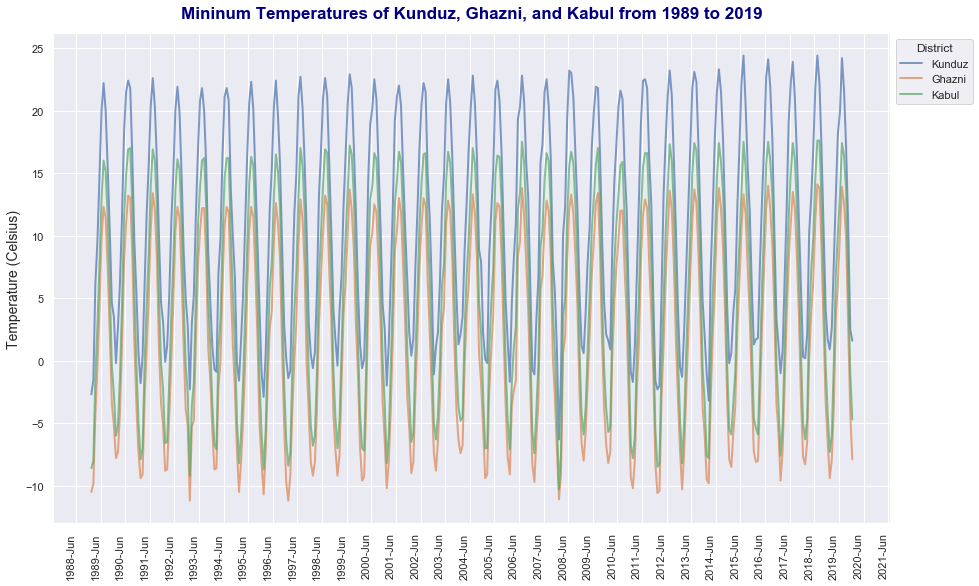

In [120]:
ax = df_min[['min_kunduz', 'min_ghazni', 'min_kabul']].plot(figsize=(15, 10), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Temperature (Celsius)')
ylabel.set_size(14)

ttl = ax.set_title('Mininum Temperatures of Kunduz, Ghazni, and Kabul from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

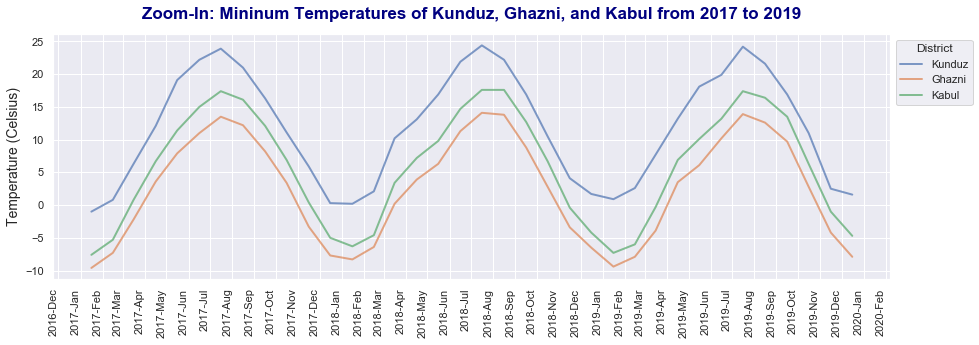

In [134]:
ax = df_min.loc['2017-01-01':][['min_kunduz', 'min_ghazni', 'min_kabul']].plot(figsize=(15, 5), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Temperature (Celsius)')
ylabel.set_size(14)

ttl = ax.set_title('Zoom-In: Mininum Temperatures of Kunduz, Ghazni, and Kabul from 2017 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

### 2.5.2 Maximum Temperature Data

In [88]:
type_dict = {'max': 'tmx'}

df_max = pd.DataFrame()

for tp, name in type_dict.items():
    
    for nc_file in glob.glob(f'data/climate_{tp}/*.nc'):
        new_df = get_one_df(nc_file, type_dict)

        df_max = pd.concat([df_max, new_df])
    
df_max.set_index('date', inplace=True)
df_max.sort_index(inplace=True)
df_max = df_max.loc['1989-01-01':]

In [89]:
df_max.head()

,max_kunduz,max_ghazni,max_kabul
date,,,
1989-01-16,7.500000,-0.5,1.000000
1989-02-15,8.700000,0.0,1.400000
1989-03-16,19.000000,7.2,9.900001
1989-04-16,24.300001,11.5,14.400001
1989-05-16,29.600000,15.5,18.400000


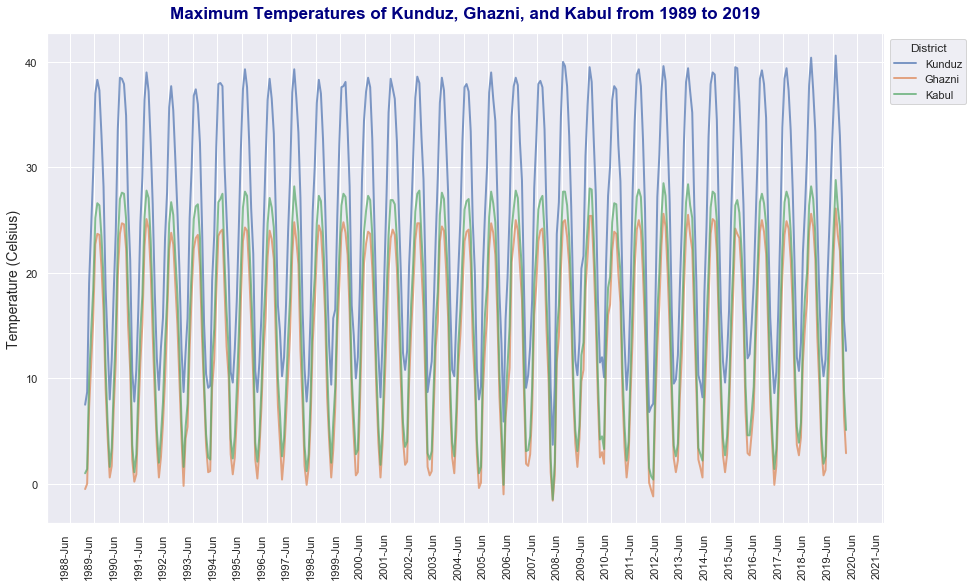

In [121]:
ax = df_max[['max_kunduz', 'max_ghazni', 'max_kabul']].plot(figsize=(15, 10), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Temperature (Celsius)')
ylabel.set_size(14)

ttl = ax.set_title('Maximum Temperatures of Kunduz, Ghazni, and Kabul from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

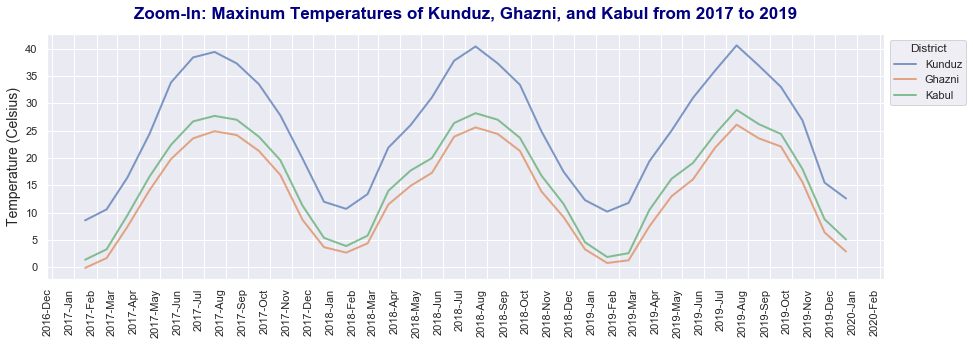

In [135]:
ax = df_max.loc['2017-01-01':][['max_kunduz', 'max_ghazni', 'max_kabul']].plot(figsize=(15, 5), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Temperature (Celsius)')
ylabel.set_size(14)

ttl = ax.set_title('Zoom-In: Maxinum Temperatures of Kunduz, Ghazni, and Kabul from 2017 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

### 2.5.3 Average Temperature Data

In [90]:
type_dict = {'avg': 'tmp'}

df_avg = pd.DataFrame()

for tp, name in type_dict.items():
    
    for nc_file in glob.glob(f'data/climate_{tp}/*.nc'):
        new_df = get_one_df(nc_file, type_dict)

        df_avg = pd.concat([df_avg, new_df])
    
df_avg.set_index('date', inplace=True)
df_avg.sort_index(inplace=True)
df_avg = df_avg.loc['1989-01-01':]

In [91]:
df_avg.head()

,avg_kunduz,avg_ghazni,avg_kabul
date,,,
1989-01-16,2.400000,-5.5,-3.8
1989-02-15,3.600000,-4.9,-3.3
1989-03-16,12.500000,1.4,4.3
1989-04-16,16.900000,5.5,8.6
1989-05-16,22.200001,9.7,13.0


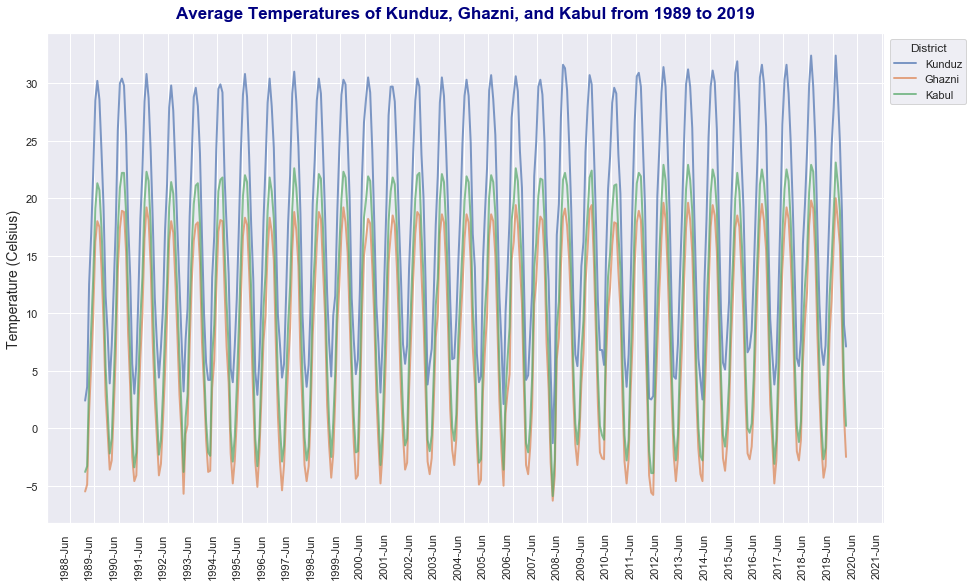

In [122]:
ax = df_avg[['avg_kunduz', 'avg_ghazni', 'avg_kabul']].plot(figsize=(15, 10), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Temperature (Celsius)')
ylabel.set_size(14)

ttl = ax.set_title('Average Temperatures of Kunduz, Ghazni, and Kabul from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

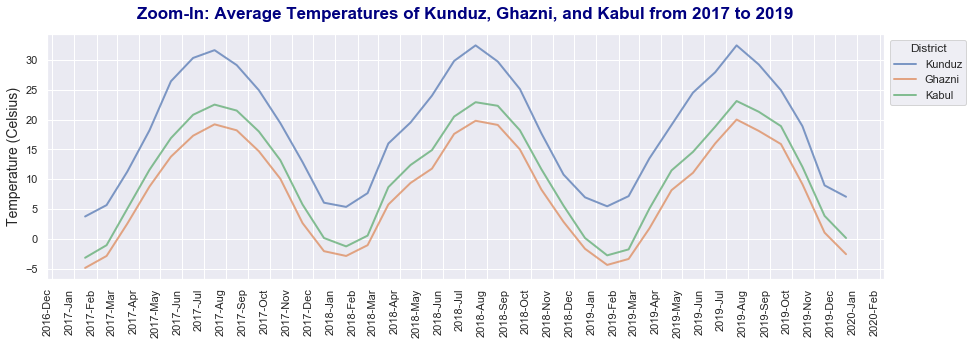

In [136]:
ax = df_avg.loc['2017-01-01':][['avg_kunduz', 'avg_ghazni', 'avg_kabul']].plot(figsize=(15, 5), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Temperature (Celsius)')
ylabel.set_size(14)

ttl = ax.set_title('Zoom-In: Average Temperatures of Kunduz, Ghazni, and Kabul from 2017 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

### 2.5.4 Precipitation

In [92]:
type_dict = {'pre': 'pre'}

df_pre = pd.DataFrame()

for tp, name in type_dict.items():
    
    for nc_file in glob.glob(f'data/climate_{tp}/*.nc'):
        new_df = get_one_df(nc_file, type_dict)

        df_pre = pd.concat([df_pre, new_df])
    
df_pre.set_index('date', inplace=True)
df_pre.sort_index(inplace=True)
df_pre = df_pre.loc['1989-01-01':]

In [93]:
df_pre.head()

,pre_kunduz,pre_ghazni,pre_kabul
date,,,
1989-01-16,34.600002,45.100002,40.100002
1989-02-15,54.200001,37.400002,62.400002
1989-03-16,82.400002,127.300003,101.599998
1989-04-16,22.500000,31.300001,34.400002
1989-05-16,58.400002,35.500000,62.000000


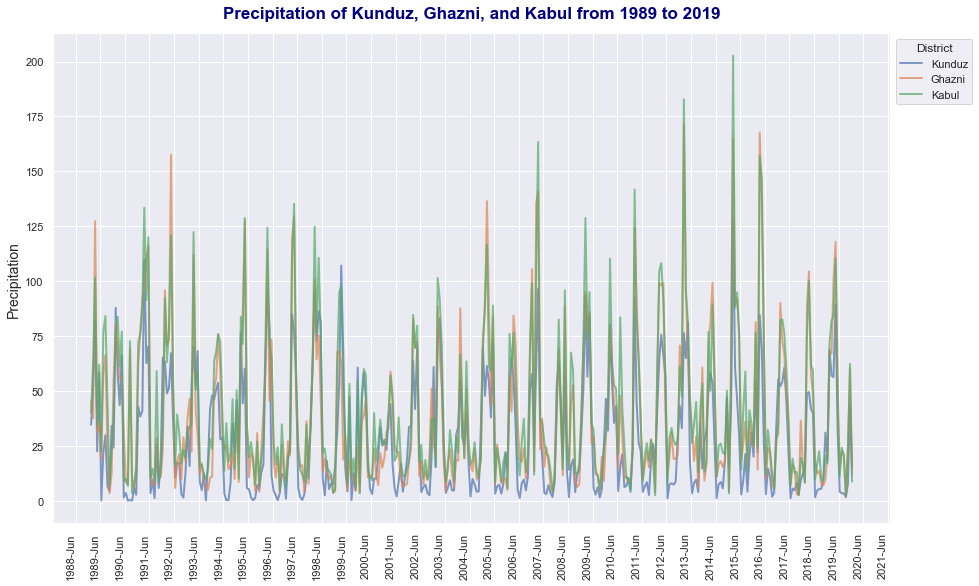

In [137]:
ax = df_pre[['pre_kunduz', 'pre_ghazni', 'pre_kabul']].plot(figsize=(15, 10), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Precipitation')
ylabel.set_size(14)

ttl = ax.set_title('Precipitation of Kunduz, Ghazni, and Kabul from 1989 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

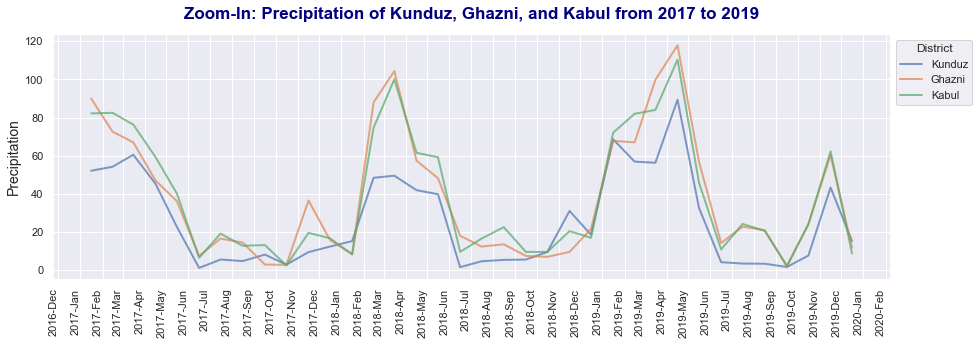

In [138]:
ax = df_pre.loc['2017-01-01':][['pre_kunduz', 'pre_ghazni', 'pre_kabul']].plot(figsize=(15, 5), lw=2, alpha=0.7)
ax.legend(title='District', labels=['Kunduz', 'Ghazni', 'Kabul'], bbox_to_anchor=(1.0, 1), loc='upper left')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
plt.xticks(rotation=90)
ax.axes.get_xaxis().get_label().set_visible(False)

ylabel = ax.set_ylabel('Precipitation')
ylabel.set_size(14)

ttl = ax.set_title('Zoom-In: Precipitation of Kunduz, Ghazni, and Kabul from 2017 to 2019', pad=15)
ttl.set_weight('bold')
ttl.set_color('navy')
ttl.set_size(17);

## 2.6 Export DataFrame

In [101]:
df_min.to_csv('exported_df/df_min.csv')
df_max.to_csv('exported_df/df_max.csv')
df_avg.to_csv('exported_df/df_avg.csv')
df_pre.to_csv('exported_df/df_pre.csv')

## References
- [Latitude and Longitude Finder](https://www.latlong.net/)
- [GitHub Repo netcdf4-python](https://github.com/Unidata/netcdf4-python)
- [Extracting time series data from a netCDF file](https://www.youtube.com/watch?v=ue55Mxe4yVQ&list=PLLxyyob7YmEE8S3QDs1PZQkiBxA4zn_Gx)